# Appendix E
I am using the UCI Sentiment Labelled Sentences dataset instead of the UCI SMS Spam Collection dataset to get some novel results.

# E.2 - Preparing the dataset

In [1]:
# Importing the dataset
import pandas as pd
from previous_chapters import random_split
data = []
with open("../chapter-6-learn/sentiment_combined.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.rstrip('\n')
        text, label = line.rsplit('\t', 1)
        data.append((text, label))
balanced_df = pd.DataFrame(data, columns=["Text", "Label"])
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("../chapter-6-learn/train.csv", index = None)
validation_df.to_csv("../chapter-6-learn/validation.csv", index = None)
test_df.to_csv("../chapter-6-learn/test.csv", index = None)

In [2]:
# Instantiating PyTorch datasets
import torch
import tiktoken
from previous_chapters import SpamDataset
tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("../chapter-6-learn/train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("../chapter-6-learn/validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("../chapter-6-learn/test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [3]:
# Creating PyTorch data loaders
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True,
                          num_workers = num_workers, drop_last = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size,
                        num_workers = num_workers, drop_last = False)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size,
                        num_workers = num_workers, drop_last = False)

In [4]:
# Print the batch dimensions
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 103])
Label batch dimensions torch.Size([8])


In [5]:
# Print the total number of batches in each dataset
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

262 training batches
38 validation batches
75 test batches


# E.3 - Initializing the model

In [6]:
# Loading a pretrained GPT model
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "So far, I had"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size = model_size, models_dir = "../chapter-5-learn/gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-10-30 10:30:37.530516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/checkpoint
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/encoder.json
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/hparams.json
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: ../chapter-5-learn/gpt2/124M/vocab.bpe


In [7]:
# Ensure the model generates coherent text
from previous_chapters import generate_text_simple, text_to_token_ids, token_ids_to_text
text_1 = "So far, I had"
token_ids = generate_text_simple(model = model, idx = text_to_token_ids(text_1, tokenizer), 
                                 max_new_tokens = 15, context_size = BASE_CONFIG["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

So far, I had no idea what to expect.

I was so excited to see the


In [8]:
# Prepare the model for classification fine-tuning
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features = 768, out_features = num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [9]:
# Calculate initial classification accuracy
from previous_chapters import calc_accuracy_loader
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches = 10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches = 10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches = 10)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 50.00%
Validation accuracy: 48.75%
Test accuracy: 52.50%


# E.4 - Parameter-efficient fine-tuning with LoRA

In [10]:
# Implementing a LoRA layer
import math
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a = math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
    
    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [11]:
# Replacing a LinearWithLoRA layer with Linear layers
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [12]:
# Define a function to apply LoRA to the earlier defined GPTModel
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            replace_linear_with_lora(module, rank, alpha)

In [13]:
# Freeze the original model parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")
for param in model.parameters():
    param.requires_grad = False
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [14]:
# Reaplce the linear layers
replace_linear_with_lora(model, rank = 16, alpha = 16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


In [15]:
# Verify that the layers have been modified as intended
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [16]:
# Calculate the initial classification accuracy
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches = 10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches = 10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches = 10)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 50.00%
Validation accuracy: 48.75%
Test accuracy: 52.50%


In [17]:
# Fine-tuning a model with LoRA layers
import time
from previous_chapters import train_classifier_simple

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.587, Val loss 2.977
Ep 1 (Step 000050): Train loss 0.738, Val loss 0.714
Ep 1 (Step 000100): Train loss 0.705, Val loss 0.712
Ep 1 (Step 000150): Train loss 0.689, Val loss 0.692
Ep 1 (Step 000200): Train loss 0.694, Val loss 0.699
Ep 1 (Step 000250): Train loss 0.694, Val loss 0.691
Training accuracy: 45.00% | Validation accuracy: 52.50%
Ep 2 (Step 000300): Train loss 0.707, Val loss 0.717
Ep 2 (Step 000350): Train loss 0.688, Val loss 0.695
Ep 2 (Step 000400): Train loss 0.688, Val loss 0.694
Ep 2 (Step 000450): Train loss 0.695, Val loss 0.696
Ep 2 (Step 000500): Train loss 0.736, Val loss 0.671
Training accuracy: 42.50% | Validation accuracy: 55.00%
Ep 3 (Step 000550): Train loss 1.210, Val loss 0.991
Ep 3 (Step 000600): Train loss 0.925, Val loss 0.798
Ep 3 (Step 000650): Train loss 0.682, Val loss 0.733
Ep 3 (Step 000700): Train loss 0.674, Val loss 0.708
Ep 3 (Step 000750): Train loss 0.715, Val loss 0.695
Training accuracy: 52.50% | Validation a

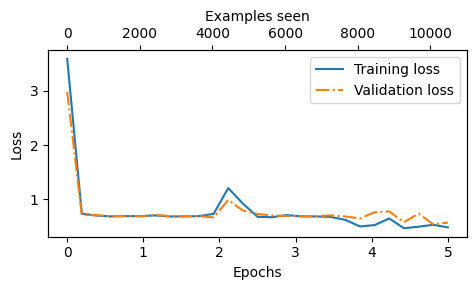

In [18]:
# Visualize the loss curves
from previous_chapters import plot_values
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

In [19]:
# Calculate the accuracy on the full dataset
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 82.06%
Validation accuracy: 79.33%
Test accuracy: 77.83%
